# Small data and deep learning
This mini-project proposes to study several techniques for improving challenging context, in which few data and resources are available.

In [1]:
%load_ext autoreload
%autoreload 2

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should not exceed 2MB. Please name your notebook (LASTNAME)\_(FIRSTNAME).ipynb, zip/tar it with any necessary files required to run your notebook, in a compressed file named (LASTNAME)\_(FIRSTNAME).X where X is the corresponding extension. Zip/tar files exceeding 2MB will not be considered for grading. Submit the compressed file via the submission link provided on the website of the class.__

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1:__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

> I obtained only the first 100 samples by inheritance from CIFAR10:

```python
class SubCIFAR10(CIFAR10):
    def __init__(self, root, length=100, **kwargs):
        self.length = length
        super().__init__(root, **kwargs)
        
    def __getitem__(self, index):
        return super().__getitem__(index % self.length)
```

In [5]:
import torchvision.transforms as transforms
import torch 
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from utils import SubCIFAR10
    
    
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 100
dataset = SubCIFAR10("datasets", download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified


View a few classes

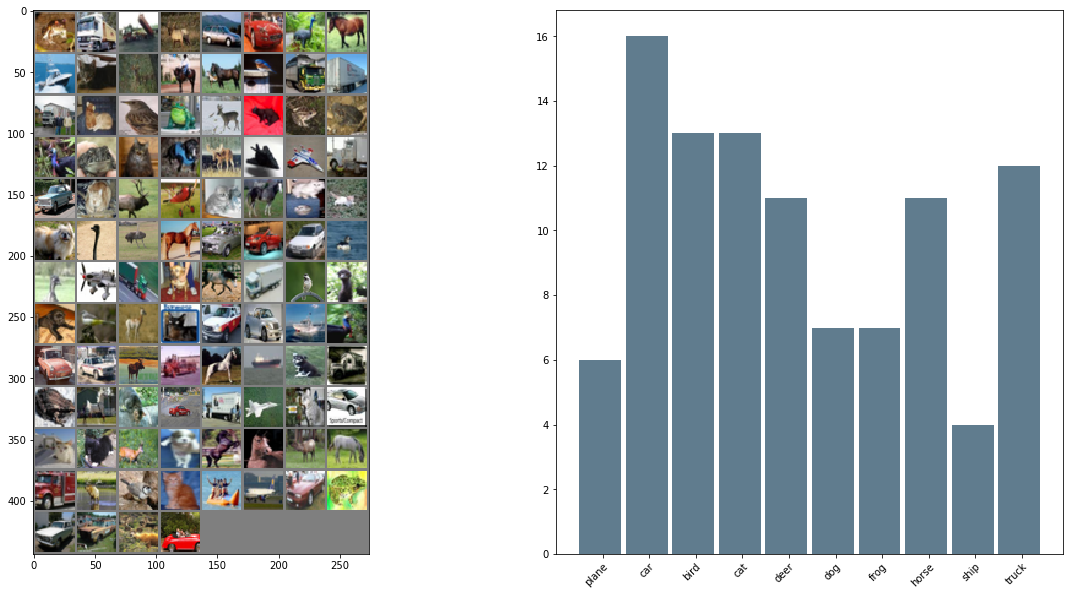

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(dataloader)
images, labels = next(dataiter)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.grid(False)
imshow(torchvision.utils.make_grid(images))

plt.subplot(122)
plt.hist(labels, bins=len(classes), rwidth=0.9, color='#607c8e')
ax = plt.gca()
plt.xticks(np.arange(len(classes))*0.9+0.5, classes, rotation=45, rotation_mode="anchor", ha="right")
plt.show()

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2:__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

> Having a very small dataset for 10 classes makes training particularly difficult. For exmaple, the class "ship" has only 4 samples. The training difficulties can be understood by the discrepancy between the number of samples and the number of parameters of a CNN (typically between hundreds of thousands to tens of millions)
>
> Several solutions exist though:
>
> - using a pre-trained network, such that the optimizer is closed to an extrema with the new challenge;
> - augmenting the number of data with random variations of original data;
> - generating new data by learning a latent representation (such as VAE) of the trainset, using adversarial network;
> - synthetising new data and possibly refining them with CycleGANs;
> - optimizing the architecture of training, such as using a smaller dataset, testing different hyperparameters;
> - making use of non-annotated data (see semi-supervised/weakly-supervised learning methods).

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performances with reported number from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context, as those researchers had access to GPUs.

## ResNet architectures

__Question 3:__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1409.1556 ). If possible, please report the accuracy obtained on the whole dataset, as well as the reference paper/GitHub link you might have used.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (~5 minutes).

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


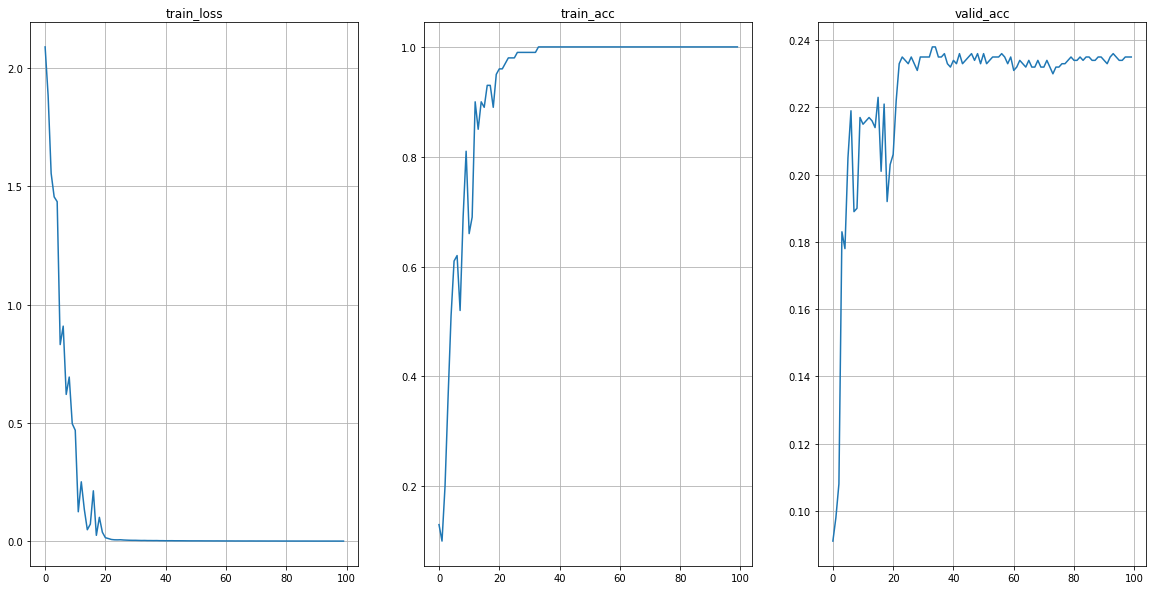

[Testing]


0.235

In [8]:
from utils import train_an_epoch, test
from resnet import ResNet18


batch_size = 10
n_epochs = 100

# Loading data
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = SubCIFAR10("datasets", download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
validset = SubCIFAR10("datasets", download=True, transform=test_transform, offset=100, length=1000)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)
testset = SubCIFAR10("datasets", download=True, transform=test_transform, offset=100, length=50000)
testloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)

# Initialize opt and net
model = ResNet18()
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()
    
# Training
train_loss = np.zeros(n_epochs, dtype=float)
train_acc = np.zeros(n_epochs, dtype=float)
valid_acc = np.zeros(n_epochs, dtype=float)
with tnrange(n_epochs) as t:
    for i in t:
        train_loss[i] = train_an_epoch(model, criterion, 
                 trainloader, optimizer, device, silent=True)
        train_acc[i] = test(model, trainloader, 
                 criterion, device, silent=True)
        valid_acc[i] = test(model, validloader, criterion, device, silent=True)
        t.set_postfix(train_loss=train_loss[i], train_acc=train_acc[i], valid_acc=valid_acc[i])
     
plot_history(train_loss=train_loss, train_acc=train_acc, valid_acc=valid_acc)
print("[Testing]")
test(model, testloader, criterion, device)

Oops... The neural network is completely over-fitting!

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|ResNet| 10 | 38.5% | 20.9% |
|ResNet| 20 | 51.5% | 23.1% |
|ResNet| 100 | 98.0% | 23.5% |
|[Keshari-ResNet]| N/A | N/A | 36% | 
|**[Keshari-ResNet-pretrained]**| N/A | N/A |44% | 

- [Keshari-ResNet] *Learning Structure and Strength of CNN Filters for Small Sample Size Training*;
Rohit Keshari, Mayank Vatsa, Richa Singh, Afzel Noore.  (version Proposed ResNet, Dict., Init., learn "t") 
- [Keshari-ResNet] - (version Proposed ResNet, Pre-trained on ImageNet, learn "t") 

## VGG-like architectures

__Question 4:__ Same question as before, but with a *VGG*. Which model do you recommend?

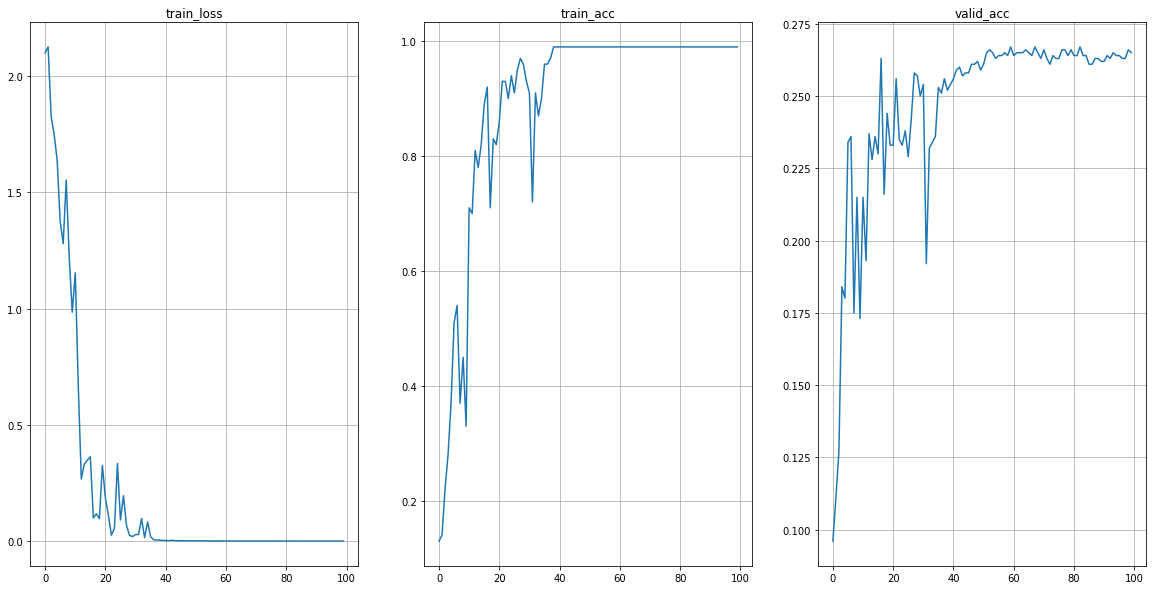

0.265

In [9]:
from vgg import VGG# Initialize opt and net
model = VGG('VGG11')
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()
    
# Training
train_loss = np.zeros(n_epochs, dtype=float)
train_acc = np.zeros(n_epochs, dtype=float)
valid_acc = np.zeros(n_epochs, dtype=float)
with tnrange(n_epochs) as t:
    for i in t:
        train_loss[i] = train_an_epoch(model, criterion, 
                 trainloader, optimizer, device, silent=True)
        train_acc[i] = test(model, trainloader, 
                 criterion, device, silent=True)
        valid_acc[i] = test(model, validloader, criterion, device, silent=True)
        t.set_postfix(train_loss=train_loss[i], train_acc=train_acc[i], valid_acc=valid_acc[i])
     
plot_history(train_loss=train_loss, train_acc=train_acc, valid_acc=valid_acc)
test(model, testloader, criterion, device)

I have tested first with VGG19, but over-fitting was even worst. I switched then to a smaller network having less parameters: VGG11. Bold lines emphasize the best results.

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|ResNet18| 10 | 38.5% | 20.9% |
|**ResNet18**| 100 | 98.0% | 23.5%|
| VGG19 |  10 | 25.0% | 17.1% |
|**VGG19** | 100 | 83.0% | 18.7% |
| VGG11 |  10 | 92.0% | 22.9% |
|**VGG11** |  14 | 100.0% | 27.0% |
| VGG11 | 100 | 100.0% | 25.3% | 
|[Keshari-ResNet]| N/A | N/A | 36% | 
|**[Keshari-ResNet-pretrained]**| N/A | N/A | 44% | 

For proposed training method, VGG11 is a better choice than ResNet18, since its converged faster and achieves a better test accuracy at step 14 (27%)


# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 5:__ Pick a model from the list above, adapt it to CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [ ]:
from torchvision.models.resnet import resnet18
from utils import plot_history, initialize_model
from tqdm import tnrange

n_epochs = 35

# Loading model and opt
model, input_size = initialize_model("resnet", len(classes), True, use_pretrained=True)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
optimizer = torch.optim.Adam(params_to_update)
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()
    
    
# Loading data    
train_transform = transforms.Compose(
    [transforms.RandomResizedCrop(input_size),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
test_transform = transforms.Compose(
    [transforms.Resize(input_size),
     transforms.CenterCrop(input_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
trainset = SubCIFAR10("datasets", download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
validset = SubCIFAR10("datasets", download=True, transform=test_transform, offset=100, length=1000)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)
testset = SubCIFAR10("datasets", download=True, transform=test_transform, offset=100, length=50000)
testloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)

    
# Training
train_loss = np.zeros(n_epochs, dtype=float)
train_acc = np.zeros(n_epochs, dtype=float)
valid_acc = np.zeros(n_epochs, dtype=float)
with tnrange(n_epochs) as t:
    for i in t:
        train_loss[i] = train_an_epoch(model, criterion, 
                 trainloader, optimizer, device, silent=True)
        train_acc[i] = test(model, trainloader, 
                 criterion, device, silent=True)
        valid_acc[i] = test(model, validloader, criterion, device, silent=True)
        t.set_postfix(train_loss=train_loss[i], train_acc=train_acc[i], valid_acc=valid_acc[i])
     
plot_history(train_loss=train_loss, train_acc=train_acc, valid_acc=valid_acc)
test(model, testloader, criterion, device)

In [112]:
test(model, testloader, criterion, device)

0.511

Using pre-trained neural networks allowed me to improve results over Keshari et al.!

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|VGG11 |  14 | 100.0% | 27.0% |
|[Keshari-ResNet]| N/A | N/A | 36% | 
|ResNet-pretrained| 10 | 63 % | 37% |
|[Keshari-ResNet-pretrained]| N/A | N/A | 44% | 
|**ResNet-pretrained**| 35 | 76% | 51% |

## DCGan features

GANs correspond to an unsupervised technique for generating images. In https://arxiv.org/pdf/1511.06434.pdf, Sec. 5.1 shows that the representation obtained from the Discriminator has some nice generalization properties on CIFAR10.

__Question 6:__  Using for instance a pretrained model from https://github.com/soumith/dcgan.torch combined with https://github.com/pytorch/examples/tree/master/dcgan, propose a model to train on $\mathcal{X}_{\text{train}}$. Train it and report its accuracy.

*Hint:* You can use the library: https://github.com/bshillingford/python-torchfile to load the weights of a model from torch(Lua) to pytorch(python).

> I tried to train both the generator and the discriminator. Using only 100 samples make it impossible. Instead, I train the GAN over the complete dataset. I know, it is cheating, but I found it interesting to get a baseline.

![best results](results/dcgan/fake_samples_epoch_611.png)

In [ ]:
import os
from gan import *
from utils import get_loaders, plot_history, train_an_epoch
from tqdm import tnrange
import numpy as np

# Parameters
output = os.path.join("results", "dcgan")
nc = 3
nz = 100 # latent Z vector
ngf = 64
ndf = 64
n_epochs = 650
batch_size = 300

os.makedirs(output, exist_ok=True)

# Building models and optimizers
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")
netG, optimizerG, netD, optimizerD = build_dcgan(
    device, nz, nc, ngf, ndf)
criterion = nn.BCELoss()

# Loading data
_, _, dataloader = get_loaders(batch_size=10, input_size=64)

gen_loss = np.zeros(n_epochs, dtype=float)
disc_loss = np.zeros(n_epochs, dtype=float)
valid_acc = np.zeros(n_epochs, dtype=float)

with tnrange(n_epochs) as t:
    for i in t:
        disc_loss[i], gen_loss[i] = train_gan_an_epoch(
            dataloader, netG, optimizerG, 
            netD, optimizerD, criterion, device, nz=nz, silent=True)
        export_gan_result(trainloader, netG, netD, device, 
                          output, i, nz=nz)
        t.set_postfix(disc_loss=disc_loss[i], 
                      gen_loss=gen_loss[i])
     
plot_history(disc_loss=disc_loss, gen_loss=gen_loss)

Then I trained a discriminator given a pre-trained generator

In [ ]:
import os
from gan import *
from utils import get_loaders, plot_history, train_an_epoch
from tqdm import tnrange
import numpy as np
import torchfile


# Parameters
output = os.path.join("results", "dcgan")
nc = 3
nz = 100 # latent Z vector
ngf = 64
ndf = 64
n_epochs = 650
batch_size = 300

os.makedirs(output, exist_ok=True)

# Building models and optimizers
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")
_, _, netD, optimizerD = build_dcgan(
    device, nz, nc, ngf, ndf)
netG = torchfile.load('models/bedrooms_4_net_G.t7')
criterion = nn.BCELoss()

# Loading data
dataloader, _, _ = get_loaders(batch_size=10, input_size=64)


disc_loss = np.zeros(n_epochs, dtype=float)

In [38]:
netD.train()

with tnrange(n_epochs) as t:
    for i in t:
        
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):

            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            t.set_postfix(loss=loss.data.tolist())
            t.update()
    return loss.data.tolist()
        disc_loss[i] = train_an_epoch(netD, criterion, 
            dataloader, optimizerD,  device, silent=True)
        export_gan_result(dataloader, netG, netD, device, 
                          output, i, nz=nz)
        t.set_postfix(disc_loss=disc_loss[i])
     
plot_history(disc_loss=disc_loss, gen_loss=gen_loss)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


torch.cuda.FloatTensor torch.cuda.FloatTensor



RuntimeError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 7:__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

## Data augmentations

__Question 8:__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ and __Question 4__ with them and report the accuracies.

In [125]:
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(0, scale=(.8,1.0), shear=5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 100
dataset = SubCIFAR10("datasets", download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# plt.figure(figsize=(20,10))
# dataiter = iter(dataloader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images))


Files already downloaded and verified


## Wavelets

__Question 9:__ Use a Scattering Transform as an input to a ResNet-like architecture. You can find a baseline here: https://arxiv.org/pdf/1703.08961.pdf.

*Hint:* You can use the following package: https://www.kymat.io/

# Weak supervision

Weakly supervised techniques permit to tackle the issue of labeled data. An introduction to those techniques can be found here: https://hazyresearch.github.io/snorkel/blog/ws_blog_post.html.

__(Open) Question 10:__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

# Conclusions

__Question 11:__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.